In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.0001
train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure", 0.2, 10)

Found 856 files belonging to 2 classes.
Using 685 files for training.
Using 171 files for validation.
label names: ['no_queen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (10, 4000)
Example label shape: (10,)


2024-03-24 22:03:59.196359: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-24 22:03:59.196385: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-24 22:03:59.196391: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-24 22:03:59.196420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-24 22:03:59.196433: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [2]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Initial models (OSBH)

## MFCCs

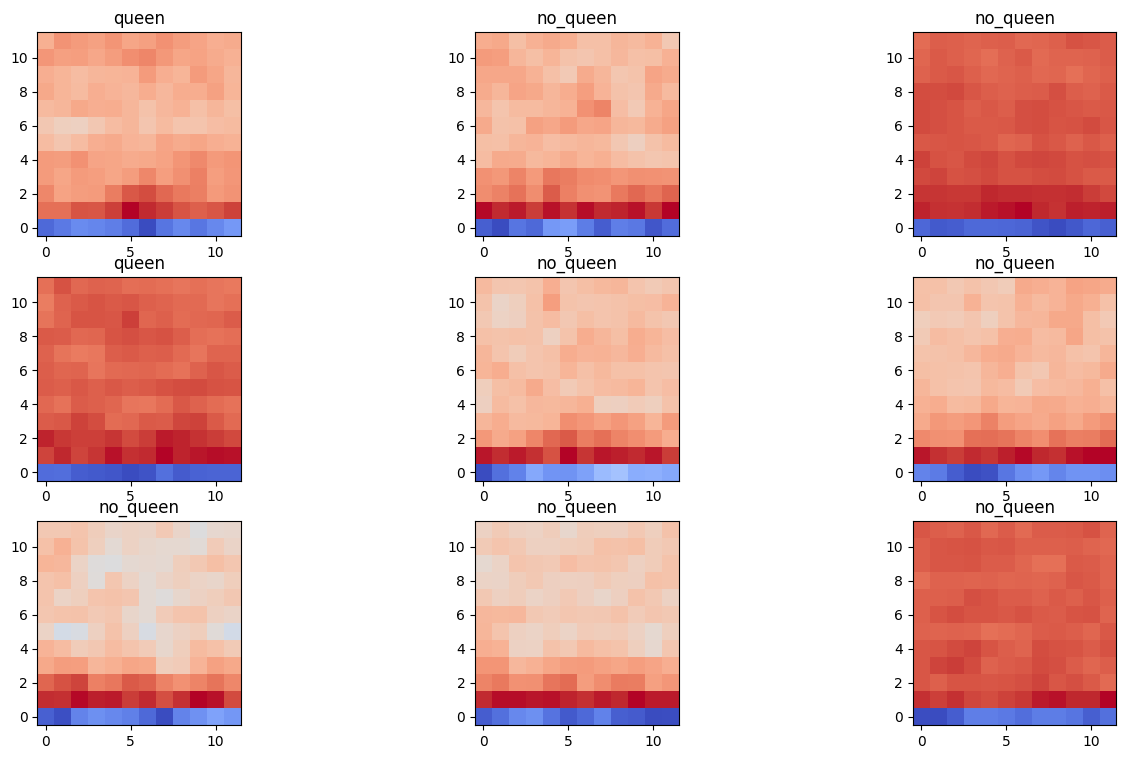

In [3]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [4]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [5]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [MFCCs] Sequential model

2024-03-24 22:04:00.611011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
 1/69 [..............................] - ETA: 31s - loss: 0.6910 - accuracy: 0.6000

2024-03-24 22:04:01.305106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


69/69 [==============================] - 2s 15ms/step - loss: 0.6031 - accuracy: 0.6380 - val_loss: 0.5083 - val_accuracy: 0.8596
Epoch 2/20
69/69 [==============================] - 1s 10ms/step - loss: 0.4099 - accuracy: 0.8642 - val_loss: 0.3412 - val_accuracy: 0.8889
Epoch 3/20
69/69 [==============================] - 1s 10ms/step - loss: 0.2930 - accuracy: 0.9109 - val_loss: 0.2538 - val_accuracy: 0.9415
Epoch 4/20
69/69 [==============================] - 1s 9ms/step - loss: 0.2499 - accuracy: 0.9270 - val_loss: 0.3032 - val_accuracy: 0.8889
Epoch 5/20
69/69 [==============================] - 1s 10ms/step - loss: 0.2415 - accuracy: 0.9226 - val_loss: 0.2456 - val_accuracy: 0.9064
Epoch 6/20
69/69 [==============================] - 1s 9ms/step - loss: 0.2248 - accuracy: 0.9299 - val_loss: 0.2711 - val_accuracy: 0.8889
Epoch 7/20
69/69 [==============================] - 1s 10ms/step - loss: 0.2159 - accuracy: 0.9270 - val_loss: 0.2560 - val_accuracy: 0.9064


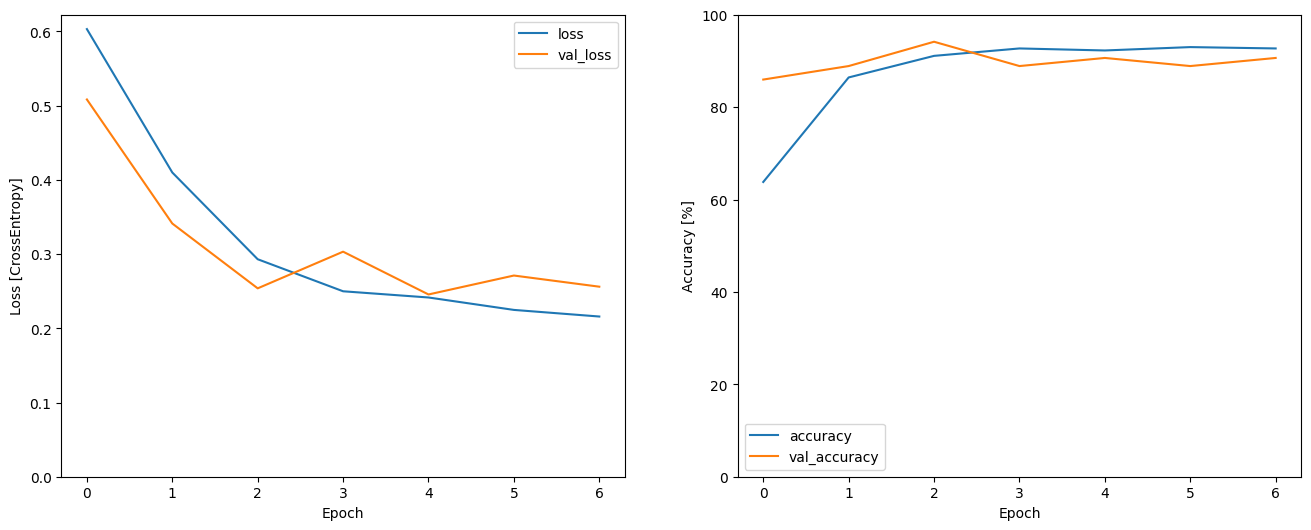

In [6]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [MFCCs] Convolutional model (mini)

Epoch 1/20
69/69 [==============================] - 1s 9ms/step - loss: 0.5919 - accuracy: 0.6350 - val_loss: 0.5143 - val_accuracy: 0.6959
Epoch 2/20
69/69 [==============================] - 0s 6ms/step - loss: 0.4954 - accuracy: 0.7854 - val_loss: 0.4318 - val_accuracy: 0.8480
Epoch 3/20
69/69 [==============================] - 0s 6ms/step - loss: 0.4248 - accuracy: 0.8453 - val_loss: 0.3706 - val_accuracy: 0.8830
Epoch 4/20
69/69 [==============================] - 0s 6ms/step - loss: 0.3756 - accuracy: 0.8774 - val_loss: 0.3248 - val_accuracy: 0.9006
Epoch 5/20
69/69 [==============================] - 0s 5ms/step - loss: 0.3338 - accuracy: 0.8920 - val_loss: 0.2927 - val_accuracy: 0.9064
Epoch 6/20
69/69 [==============================] - 0s 5ms/step - loss: 0.3064 - accuracy: 0.9007 - val_loss: 0.2619 - val_accuracy: 0.9240
Epoch 7/20
69/69 [==============================] - 0s 5ms/step - loss: 0.2845 - accuracy: 0.9051 - val_loss: 0.2508 - val_accuracy: 0.9064
Epoch 8/20
69/69 [==

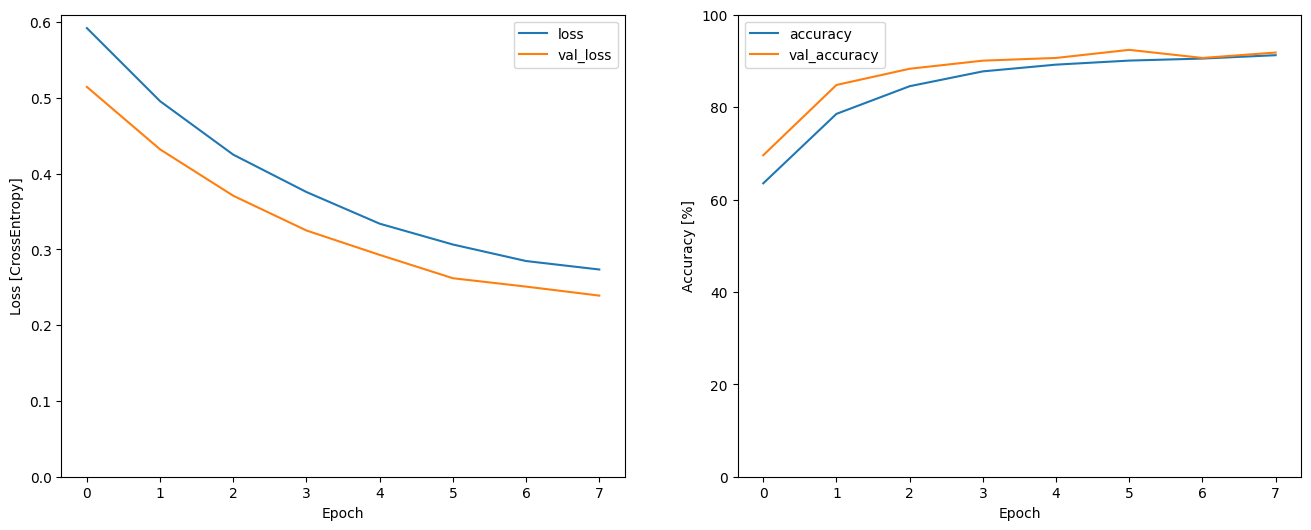

In [7]:
model_mfcc_conv = get_conv_model(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Spectrograms

(118, 129, 1)


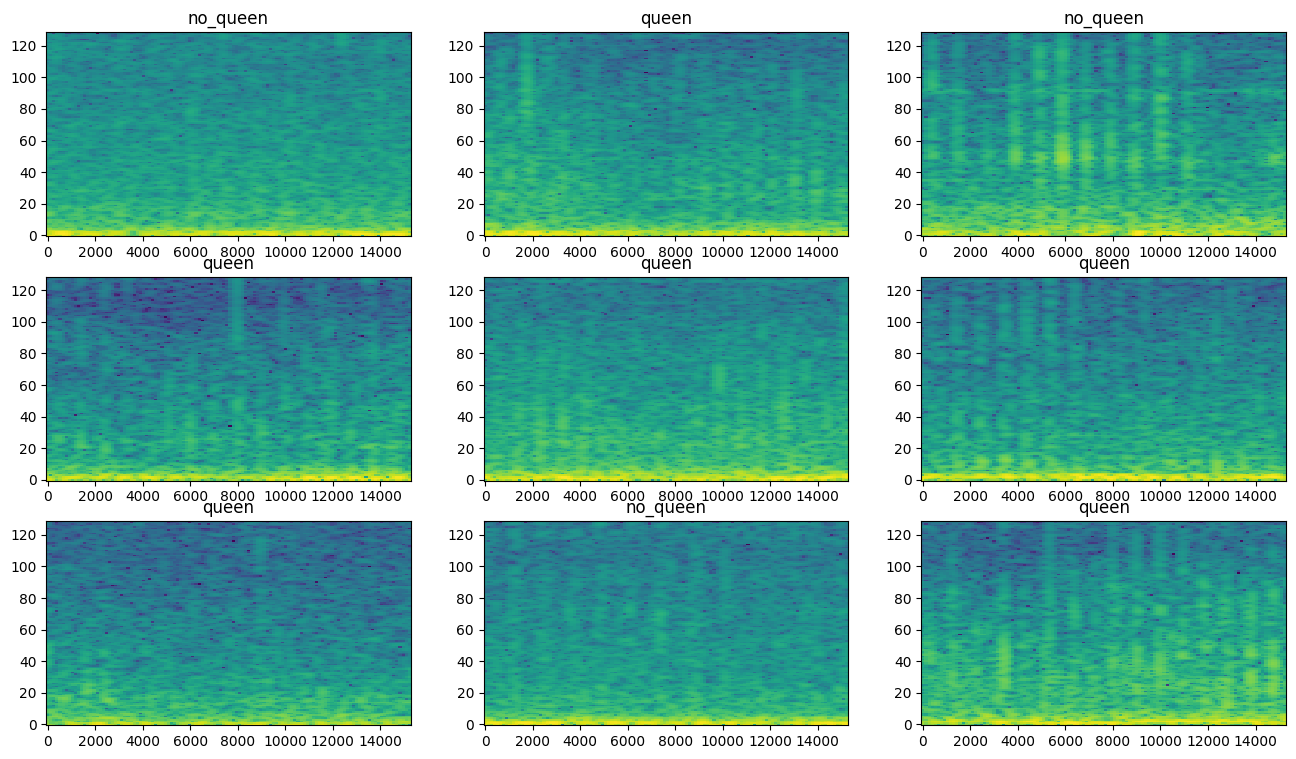

In [8]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [9]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Spec] Sequential model

Epoch 1/20
69/69 [==============================] - 1s 13ms/step - loss: 0.6388 - accuracy: 0.5985 - val_loss: 0.6286 - val_accuracy: 0.6140
Epoch 2/20
69/69 [==============================] - 1s 11ms/step - loss: 0.5825 - accuracy: 0.6599 - val_loss: 0.5525 - val_accuracy: 0.6433
Epoch 3/20
69/69 [==============================] - 1s 10ms/step - loss: 0.4852 - accuracy: 0.7796 - val_loss: 0.4546 - val_accuracy: 0.7544
Epoch 4/20
69/69 [==============================] - 1s 10ms/step - loss: 0.4097 - accuracy: 0.8234 - val_loss: 0.3807 - val_accuracy: 0.8480
Epoch 5/20
69/69 [==============================] - 1s 10ms/step - loss: 0.3229 - accuracy: 0.8686 - val_loss: 0.2905 - val_accuracy: 0.9357
Epoch 6/20
69/69 [==============================] - 1s 10ms/step - loss: 0.2730 - accuracy: 0.9007 - val_loss: 0.2653 - val_accuracy: 0.9064
Epoch 7/20
69/69 [==============================] - 1s 10ms/step - loss: 0.2546 - accuracy: 0.9066 - val_loss: 0.2509 - val_accuracy: 0.8947


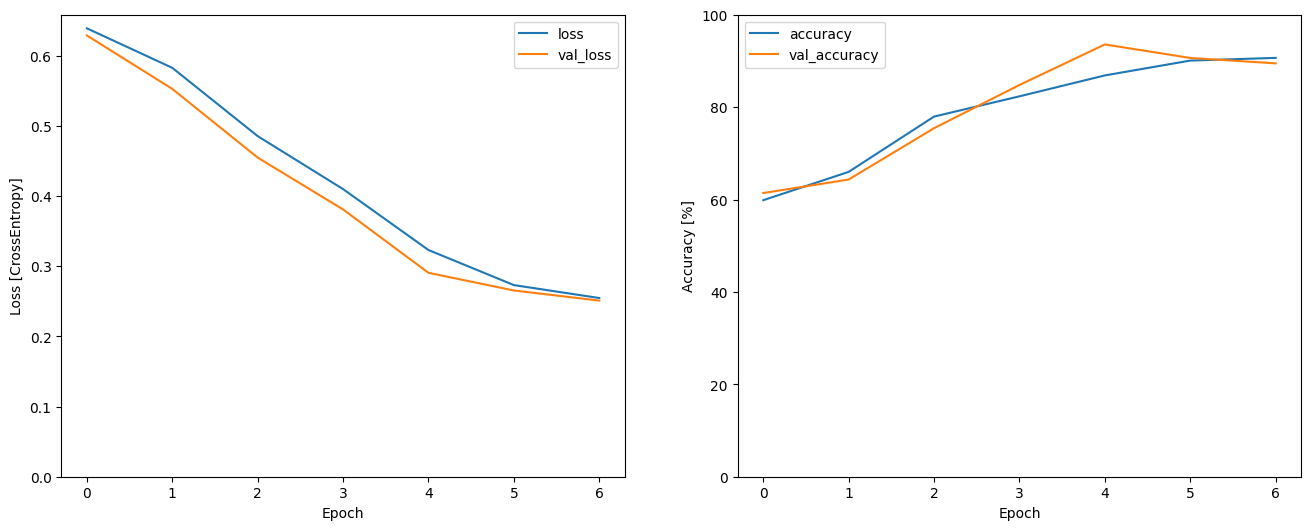

In [10]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Spec] Convolutional model

Epoch 1/20
69/69 [==============================] - 1s 10ms/step - loss: 0.5979 - accuracy: 0.6672 - val_loss: 0.5280 - val_accuracy: 0.7076
Epoch 2/20
69/69 [==============================] - 0s 6ms/step - loss: 0.4478 - accuracy: 0.8423 - val_loss: 0.3821 - val_accuracy: 0.8363
Epoch 3/20
69/69 [==============================] - 0s 6ms/step - loss: 0.3357 - accuracy: 0.8905 - val_loss: 0.3060 - val_accuracy: 0.9006
Epoch 4/20
69/69 [==============================] - 1s 8ms/step - loss: 0.2766 - accuracy: 0.9095 - val_loss: 0.2503 - val_accuracy: 0.9240
Epoch 5/20
69/69 [==============================] - 0s 6ms/step - loss: 0.2492 - accuracy: 0.9095 - val_loss: 0.2130 - val_accuracy: 0.9532
Epoch 6/20
69/69 [==============================] - 0s 6ms/step - loss: 0.2177 - accuracy: 0.9226 - val_loss: 0.1869 - val_accuracy: 0.9591
Epoch 7/20
69/69 [==============================] - 0s 6ms/step - loss: 0.1997 - accuracy: 0.9299 - val_loss: 0.1824 - val_accuracy: 0.9591
Epoch 8/20
69/69 [=

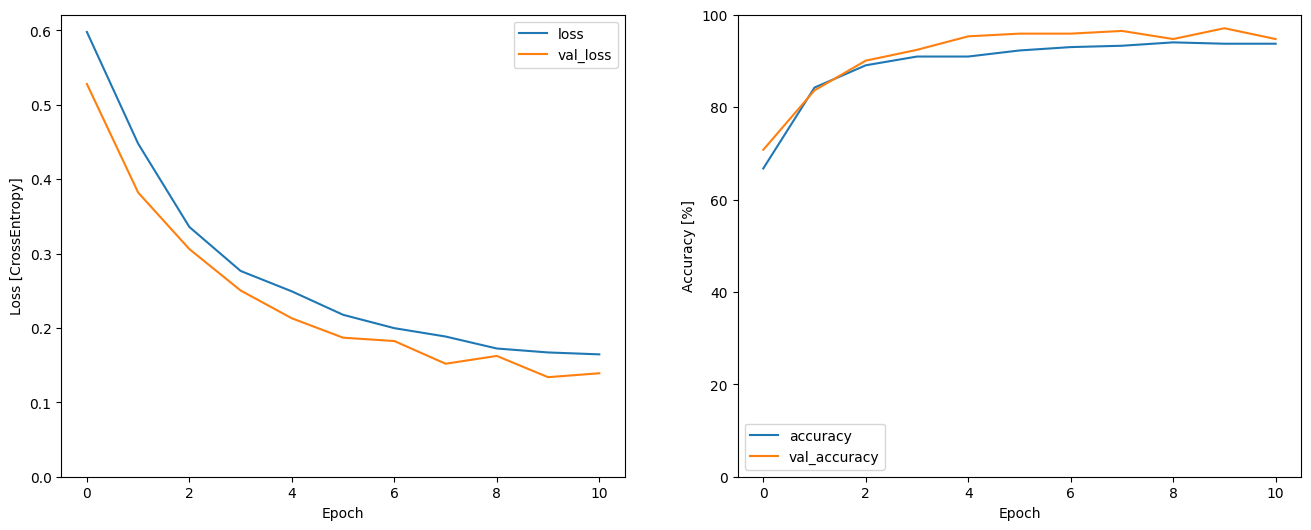

In [11]:
model_spec_conv = get_conv_model_mini(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Save models

In [12]:
model_mfcc_seq.save('models/mfcc_seq.h5')
model_mfcc_conv.save('models/mfcc_conv_mini.h5')
model_spec_seq.save('models/spec_seq.h5')
model_spec_conv.save('models/spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
history_spec_conv

# Summary

In [14]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, Val. Loss: {history.history['val_loss'][-1]:.2f}, Val. Acc: {history.history['val_accuracy'][-1]:.2f}" )

history_to_summary("MFCCs + Sequential model       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv model             ", history_mfcc_conv)
history_to_summary("Spectrogram + Sequential model ", history_spec_seq)
history_to_summary("Spectrogram + Conv model       ", history_spec_conv)


MFCCs + Sequential model       :    Loss: 0.22, Acc: 0.93, Val. Loss: 0.26, Val. Acc: 0.91
MFCCs + Conv model             :    Loss: 0.27, Acc: 0.91, Val. Loss: 0.24, Val. Acc: 0.92
Spectrogram + Sequential model :    Loss: 0.25, Acc: 0.91, Val. Loss: 0.25, Val. Acc: 0.89
Spectrogram + Conv model       :    Loss: 0.16, Acc: 0.94, Val. Loss: 0.14, Val. Acc: 0.95
